# Model training
## Load required packages
Install and import YOLOv8 packages and libraries

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 595 kB 8.8 kB/s eta 0:00:01
     |███████▋                        | 14.8 MB 7.4 kB/s eta 1:46:367

In [ ]:
# Start training from a pretrained *.pt model
# !yolo detect train data=tballs.yaml model=yolov8n.pt epochs=10 imgsz=640

# Build a new model from YAML and start training from scratch
# yolo detect train data=tballs.yaml model=yolov8n.yaml epochs=10 imgsz=640

# Build a new model from YAML, transfer pretrained weights to it and start training
# yolo detect train data=tballs.yaml model=yolov8n.yaml pretrained=yolov8n.pt epochs=10 imgsz=640


## Preparing Data
With the train-test-validation dataset already uploaded onto cnvrg.io and specified while provisioning the workspace, the dataset can be referred to under `/data`

In [4]:
!ls /data
!ls /data/license-plate
!ls /data/license-plate/train

license-plate
test  train  validation
images	labels


## Train YOLOv8 model
Using YOLOv8 as the foundational model, we can train and fit the model to detect specific objects.

In [ ]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8n.yaml')  # build a new model from YAML
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# Train the model
model.train(data='lpd.yaml', epochs=100, imgsz=640, device='cpu')

## Validate Model
Validate the trained YOLOv8 model accuracy

In [3]:
from ultralytics import YOLO
# Load a model
# model = YOLO('yolov8n.pt')  # load an official model
model = YOLO('runs/detect/train/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Ultralytics YOLOv8.0.115 🚀 Python-3.8.10 torch-1.14.0a0+44dac51 CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 63.6MB/s]
val: Scanning /data/license-plate/validation/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:20<00:00,  2.92s/it]
                   all        100        132      0.975      0.833      0.912      0.602
Speed: 3.7ms preprocess, 182.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val


array([     0.6024])

## Prediction
Having the freshly-trained model, we can now use it to predict what we are primarily interested in
### Define plotting functions

In [18]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
    if labels == []:
        labels = {0: u'__background__', 1: u'License Plate'}
    #Define colors
    if colors == []:
        colors = [(255, 100, 100), (253, 246, 160), (40, 132, 70)]
                  
    #plot each boxes
    for box in boxes:
      #add score in label if score=True
        if score:
            label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
        else:
            label = labels[int(box[-1])+1]
        #filter every box under conf threshold if conf threshold setted
        if conf:
            if box[-2] > conf:
                color = colors[int(box[-1])]
                box_label(image, box, label, color)
            else:
                color = colors[int(box[-1])]
                box_label(image, box, label, color)
    
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

### Predicting an image


0: 448x640 1 License Plate, 157.2ms
Speed: 3.2ms preprocess, 157.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


tensor([[ 56.3617, 110.7876,  83.8203, 121.6043,   0.7169,   0.0000]])


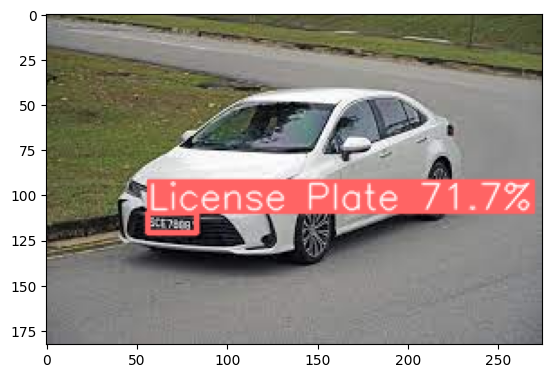

In [28]:
# response = requests.get("https://www.verywellhealth.com/thmb/bcNgrTUluaM97A33EcuVUwt_HXk=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/125847528-56a884c73df78cf7729e83dc.jpg")
# image = Image.open(BytesIO(response.content))
image = Image.open("test-images/02.jpg")

image = np.asarray(image)
    
results = model.predict(image)
print(results[0].boxes.data)
plot_bboxes(image, results[0].boxes.data, conf=0.1)


0: 448x640 1 License Plate, 140.3ms
Speed: 2.1ms preprocess, 140.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


tensor([[ 56.3617, 110.7876,  83.8203, 121.6043,   0.7169,   0.0000]])


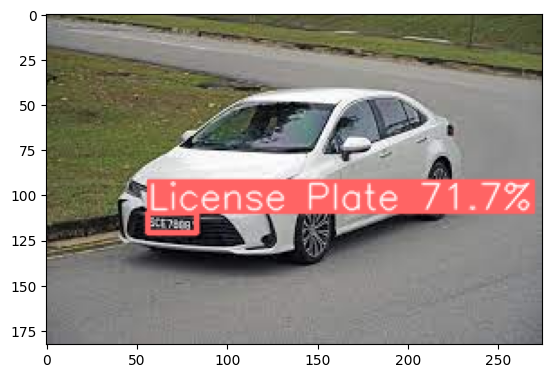

In [32]:
images = []
image = Image.open("test-images/02.jpg")
image = np.asarray(image)
images.append(image)

model = YOLO('runs/detect/train/weights/best.pt')  # load a custom model
results = model(images)
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    probs = result.probs  # Class probabilities for classification outputs
    print(boxes.data)
    plot_bboxes(image, boxes.data, conf=0.1)


## Training and Prediction using CLI
We can execute what we did in python using the yolo CLI as well, with training and prediction commands

In [ ]:
# yolo detect val model=yolov8n.pt  # val official model
# yolo detect val model=path/to/best.pt  # val custom model

In [40]:
# yolo detect predict model=yolov8n.pt source='https://ultralytics.com/images/bus.jpg'  # predict with official model
# !yolo detect predict model=runs/detect/train/weights/best.pt source='https://www.verywellhealth.com/thmb/bcNgrTUluaM97A33EcuVUwt_HXk=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/125847528-56a884c73df78cf7729e83dc.jpg'

Ultralytics YOLOv8.0.113 🚀 Python-3.8.10 torch-1.14.0a0+44dac51 CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients

100%|█████████████████████████████████████████| 135k/135k [00:00<00:00, 208kB/s]
image 1/1 /cnvrg/125847528-56a884c73df78cf7729e83dc.jpg: 448x640 1 Tennis Ball, 85.3ms
Speed: 11.1ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


In [18]:
# Copy trained weight to output folder
!cp runs/detect/train/weights/best.pt output/best.pt

## Export Model
Export the model into your desired format

In [ ]:
# Load a model
model = YOLO('runs/detect/train/weights/best.ptt')  # load a custom trained

# Export the model
model.export(format='onnx')